In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
path='/Volumes/Reiterlab_3/E2f7_em3/E2f7_em3/Hom_B/'
results_file = path + 'v3/Hom_B_v3_scanpy.h5ad' 

In [3]:
adata = sc.read_10x_mtx(
    path+ 'outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)   

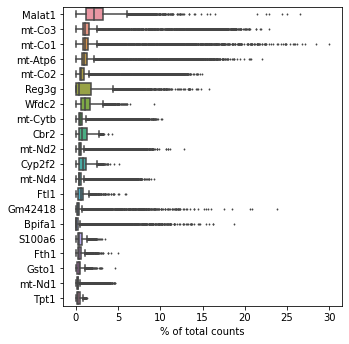

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


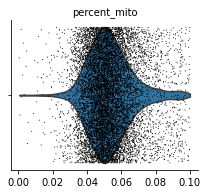

In [7]:
adata = adata[adata.obs['n_genes'] > 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.1, :]
adata = adata[adata.obs['n_counts'] < 50000, :]
sc.pl.violin(adata, ['percent_mito'],jitter=0.4, multi_panel=True)

In [8]:
adata

AnnData object with n_obs × n_vars = 10173 × 21901 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [9]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

adata.raw = adata

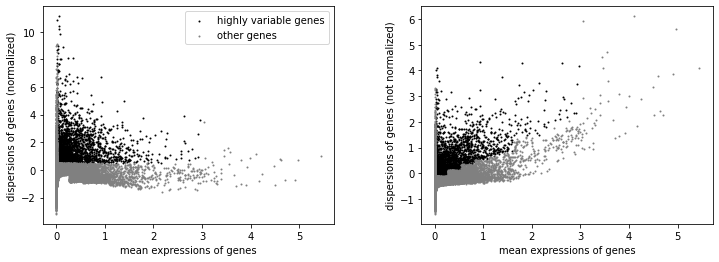

In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [11]:
adata = adata[:, adata.var['highly_variable']]

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


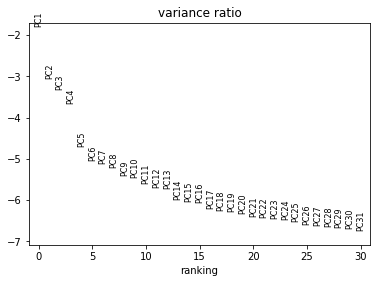

In [12]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Users/lb

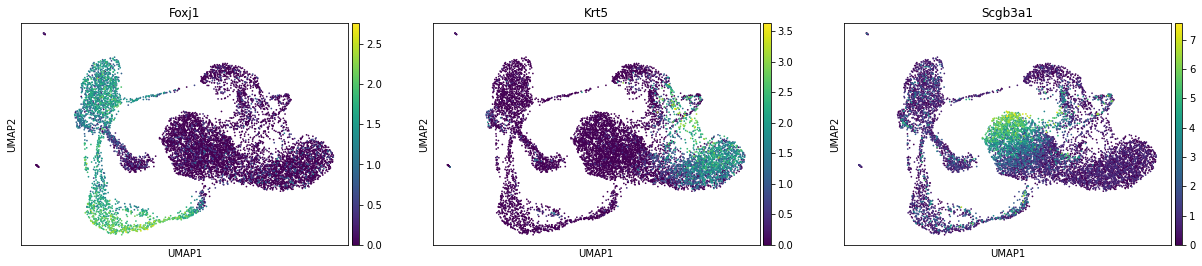

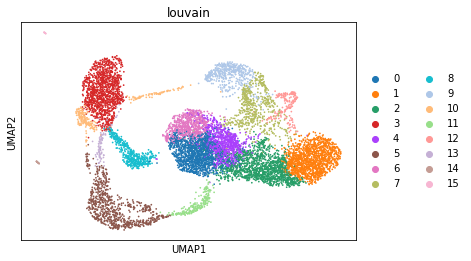

In [13]:

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

sc.tl.umap(adata)

sc.pl.umap(adata, color=['Foxj1', 'Krt5', 'Scgb3a1'])

sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'])



In [14]:
adata.write(results_file)

In [15]:
####### doublets ##########

import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os


In [16]:
counts_matrix = adata.raw.X
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))

Counts matrix shape: 10173 rows, 21901 columns


In [17]:

scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=.08)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...


/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 61.4%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 3.6%
Elapsed time: 18.8 seconds


Detected doublet rate = 3.4%
Estimated detectable doublet fraction = 68.1%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 5.0%


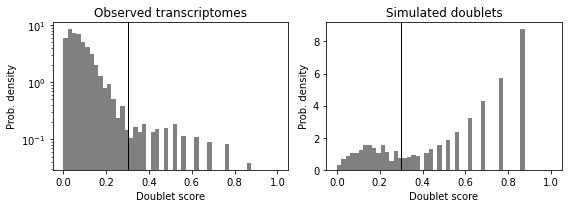

In [18]:
predicted_doublets = scrub.call_doublets(threshold=0.30)

scrub.plot_histogram();

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Use

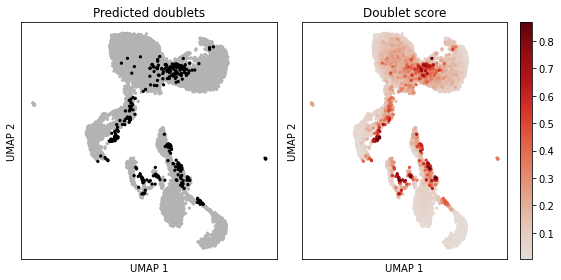

In [19]:

scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);
#plt.savefig('/Users/lb/Documents/Reiter_Seq/10X_042519/NS_analysis/scanpy/NS_scrublet_3.5perc_thresh016_umap.png')




In [20]:
cellbarc = adata.obs.index

df=pd.DataFrame({
        'cell_barcodes':cellbarc,
        'doublet_score':scrub.doublet_scores_obs_,
        'predicted_doublet':scrub.predicted_doublets_
        })
df.to_csv(path+'v3/Hom_B_scrublet_08perc_thresh0.30_output_table.csv',index=False)